In [52]:
import requests
import os
import pandas as pd
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Data preparation

In [7]:
df = pd.read_csv('/home/aiffel0042/aiffel/anomaly_detection/nasdaq/nasdaq.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [8]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

결측 날짜가 1073일이나 있습니다.

In [9]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6172
삭제 후 데이터 길이(일자수): 5099


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Data visualisation

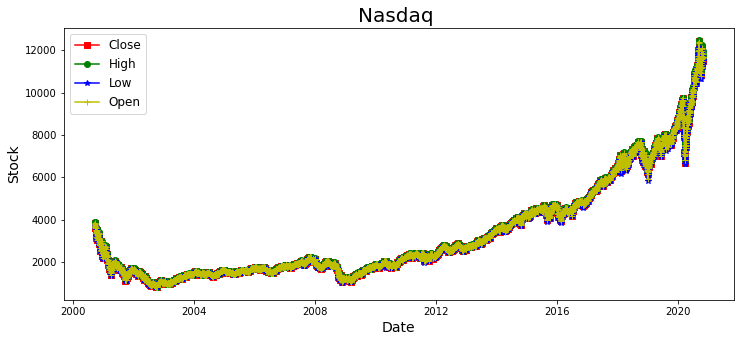

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Nasdaq ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

# Statistical approach

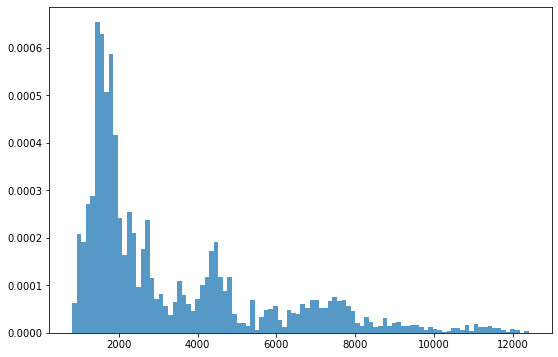

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [19]:
_, p = ztest(df.Close)
print(p)

0.0


p가 0.05 이하로 나왔으므로 normal distribution과 거리가 멀다는 뜻.

### Time series decompose

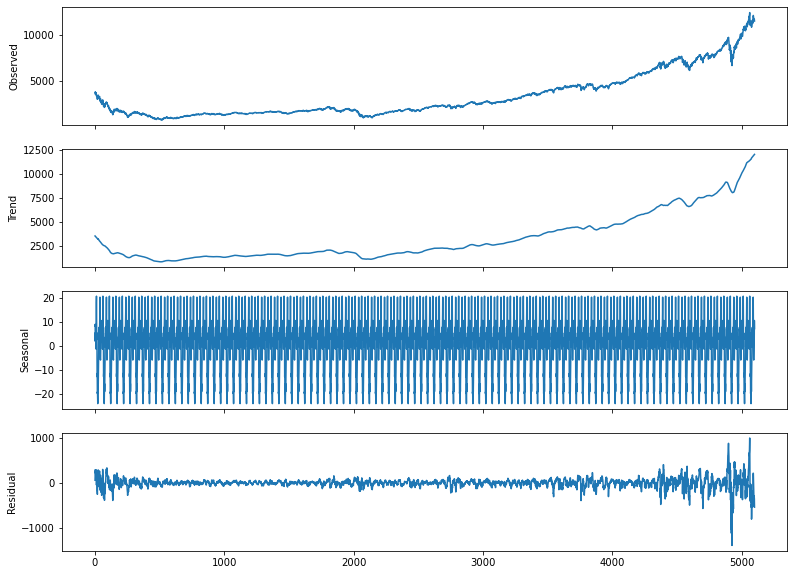

In [23]:
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(13,10))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

추세Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 볼까요?   
잔차는 평균 0을 기준으로 분포하고 있어요!   
잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?   
그럼 Residual의 분포를 그려보도록 하겠습니다   

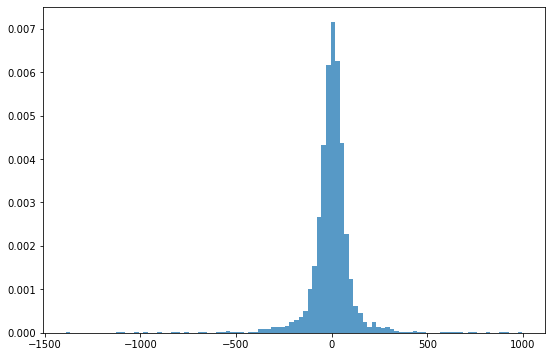

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [26]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8449533764699358 0.3981368709039024


p가 0.05보다 크므로 정규분포를 따른다고 할 수 있다.

### 3σ 기준 신뢰구간으로 이상치 찾기

In [27]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2999120663276504 표준편차: 109.85598825288083
이상치 갯수: 91


In [33]:
pd.set_option('display.max_row', 500)
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]


66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
137    2001-04-04
3757   2015-08-24
3758   2015-08-25
4373   2018-02-08
4374   2018-02-09
4393   2018-03-09
4394   2018-03-12
4408   2018-04-02
4554   2018-10-29
4577   2018-12-03
4590   2018-12-21
4591   2018-12-26
4593   2018-12-28
4596   2019-01-03
4696   2019-05-29
4698   2019-05-31
4699   2019-06-03
4700   2019-06-04
4701   2019-06-05
4742   2019-08-05
4890   2020-02-10
4891   2020-02-11
4892   2020-02-12
4893   2020-02-13
4894   2020-02-14
4895   2020-02-16
4896   2020-02-18
4897   2020-02-19
4898   2020-02-20
4899   2020-02-21
4900   2020-02-23
4901   2020-02-24
4909   2020-03-04
4913   2020-03-09
4916   2020-03-12
4918   2020-03-15
4919   2020-03-16
4920   2020-03-17
4921   2020-03-18
4922   2020-03-19
4923   2020-03-20
4924   2020-03-22
4925   2020-03-23
4926   2020-03-24
4927   2020-03-25
4929   2020-03-27
4930   2020-03-29
4933   2020-04-01
4934   2020-04-02
4935   2020-04-03
4942   202

3σ 밖을 벗어나는 데이터(0.26%)를 이상치로 간주하고 91개를 뽑아냈다. 2020년 하반기부터 오늘(2020/10/27)까지 이상치로 간주되는 데이터가 몰려있는 것으로 보아 코로나 때문임을 짐작할 수 있다.

# Unsupervised clustering

### Preprocessing

In [29]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,3332.330515,3363.855745,3300.111907,3334.217782,288130.461031
std,2403.391909,2425.438732,2382.102203,2407.330351,109938.975816
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.475000,1597.732500,1571.207500,1584.428000,220602.630000
50%,2264.890000,2292.520000,2232.222500,2265.365898,268966.970000
75%,4434.496250,4466.726250,4401.212500,4435.423750,319713.305000
max,12033.042071,12196.758183,11862.766066,12040.730510,776809.340000


In [30]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,-1.341047,-1.425657,-1.245539,-1.324893,111.329053
std,112.064170,101.933819,116.392388,110.012361,110684.147816
min,-1280.680386,-1494.824059,-1227.099256,-1390.323879,-602783.228571
25%,-38.166494,-35.390621,-38.026891,-37.759554,-53332.330890
50%,3.303978,3.282985,3.989810,3.002597,-543.740417
75%,40.134378,37.587873,42.050847,40.867349,51441.465982
max,996.974738,933.605894,944.588455,996.310109,810669.327959


In [34]:
# 표준정규화
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.34104664  -1.42565666  -1.24553873  -1.32489327 111.32905299]


array([[ 0.95049097,  0.8474392 ,  0.81778679,  0.602076  ,  0.08324263],
       [ 0.49107995,  1.28568589,  1.38927839,  2.09633001,  0.10456865],
       [ 1.91066005,  2.02071299,  2.04939104,  2.73893222, -0.08890357],
       ...,
       [-2.82945994, -4.24460804, -2.81850532, -3.2638577 ,  0.36342897],
       [-3.12271671, -4.82026893, -2.62886854, -3.3617078 , -0.28818501],
       [-3.65110382, -4.98785578, -4.53564258, -5.03931076, -0.44039074]])

### Clustering 1: k-means 로 이상치 탐색하기

In [38]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [39]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1104 3995]


In [40]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:105',
 'group:1-count:1046',
 'group:2-count:284',
 'group:3-count:530',
 'group:4-count:32',
 'group:5-count:20',
 'group:6-count:435',
 'group:7-count:280',
 'group:8-count:1029',
 'group:9-count:94',
 'group:10-count:11',
 'group:11-count:682',
 'group:12-count:32',
 'group:13-count:71',
 'group:14-count:448']

적은 수로 형성된 4,5,10,12 그룹을 더 파헤쳐 봅니다.

In [42]:
df[(kmeans.labels_==4)|(kmeans.labels_==5)|(kmeans.labels_==10)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
137,2001-04-04,1407.500000,1451.000000,1361.000000,1379.500000,1379.500000,141811.0
845,2004-01-15,1532.000000,1548.500000,1516.000000,1537.500000,1537.500000,487414.0
846,2004-01-16,1536.500000,1556.000000,1535.500000,1553.000000,1553.000000,487414.0
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1742,2007-07-26,2026.500000,2039.500000,1969.250000,2000.500000,2000.500000,808824.0
1805,2007-10-24,2207.000000,2209.250000,2154.000000,2203.000000,2203.000000,697409.0
1816,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0
4239,2017-07-27,5961.000000,5995.750000,5844.750000,5909.500000,5909.500000,539445.0
4313,2017-11-09,6342.250000,6351.500000,6244.750000,6314.500000,6314.500000,550267.0
4325,2017-11-29,6423.500000,6428.500000,6283.000000,6305.500000,6305.500000,625761.0


In [43]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5.099000e+03
mean,3330.987427,3362.428861,3298.864707,3332.891614,3332.891614,2.882423e+05
std,2403.558364,2424.701776,2382.888256,2407.248195,2407.248195,1.595762e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1594.000000,1608.500000,1576.500000,1593.250000,1593.250000,1.907535e+05
50%,2233.000000,2260.000000,2212.000000,2233.500000,2233.500000,2.657480e+05
75%,4447.750000,4474.500000,4420.750000,4451.875000,4451.875000,3.562595e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


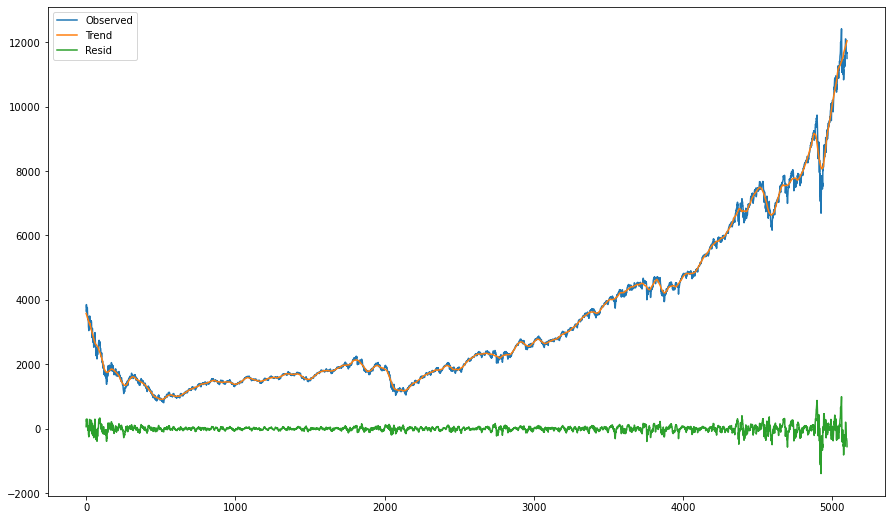

In [44]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

별 이상한 점은 없어보인다.

### Clustering 2: DBSCAN 으로 이상치 찾기

In [49]:
clustering = DBSCAN(eps=0.3, min_samples=4).fit(norm_rdf)
clustering

DBSCAN(eps=0.3, min_samples=4)

In [50]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0 -1 -1 ... -1 -1 -1]


In [51]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:850',
 'group:0-count:4206',
 'group:1-count:4',
 'group:2-count:4',
 'group:3-count:11',
 'group:4-count:8',
 'group:5-count:7',
 'group:6-count:6',
 'group:7-count:3']

### Forecasting: Auto-Encoder를 이용한 이상치 탐색

In [53]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [54]:
# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [57]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [56]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [58]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [59]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/160 [============================>.] - ETA: 0s - loss: 1.7230 - mae: 1.7230
Epoch 00001: val_loss improved from inf to 2.07806, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
160/160 [==============================] - 5s 34ms/step - loss: 1.7540 - mae: 1.7540 - val_loss: 2.0781 - val_mae: 2.0781
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.9385 - mae: 0.9385
Epoch 00002: val_loss improved from 2.07806 to 1.05978, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
160/160 [==============================] - 6s 35ms/step - loss: 0.9385 - mae: 0.9385 - val_loss: 1.0598 - val_mae: 1.0598
Epoch 3/50
159/160 [============================>.] - ETA: 0s - loss: 0.5365 - mae: 0.5365
Epoch 00003: val_loss improved from 1.05978 to 0.74842, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
160/160 [==============================] - 6s 35ms/step - loss: 0.5419 - mae: 0.5419 - v

In [60]:
model.load_weights(checkpoint_path)

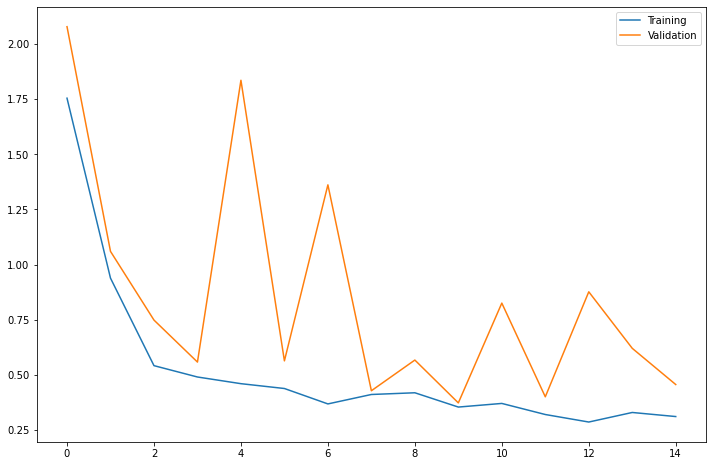

In [61]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

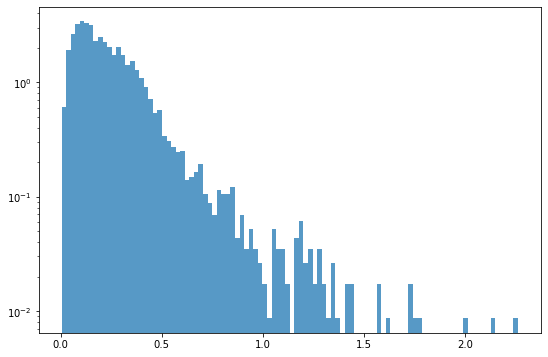

In [62]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [63]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss


In [64]:
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
0,2000-10-02,3621.000000,3668.000000,3492.000000,3528.500000,3528.500000,63100.0,0.364042
1,2000-10-03,3529.000000,3603.000000,3385.000000,3397.000000,3397.000000,78732.0,0.360837
2,2000-10-04,3426.500000,3477.500000,3334.000000,3477.500000,3477.500000,77551.0,0.333492
3,2000-10-05,3460.500000,3537.000000,3431.500000,3482.500000,3482.500000,69864.0,0.301879
4,2000-10-06,3490.000000,3509.500000,3305.000000,3357.500000,3357.500000,69256.0,0.371742
...,...,...,...,...,...,...,...,...
5084,2020-10-20,11697.500000,11792.000000,11598.500000,11660.799805,11660.799805,622702.0,0.525717
5085,2020-10-21,11675.200195,11779.200195,11585.000000,11691.200195,11691.200195,599851.0,0.534289
5086,2020-10-22,11683.500000,11724.000000,11511.000000,11649.799805,11649.799805,583669.0,0.526199
5087,2020-10-23,11669.200195,11691.799805,11551.000000,11663.500000,11663.500000,501243.0,0.643934


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


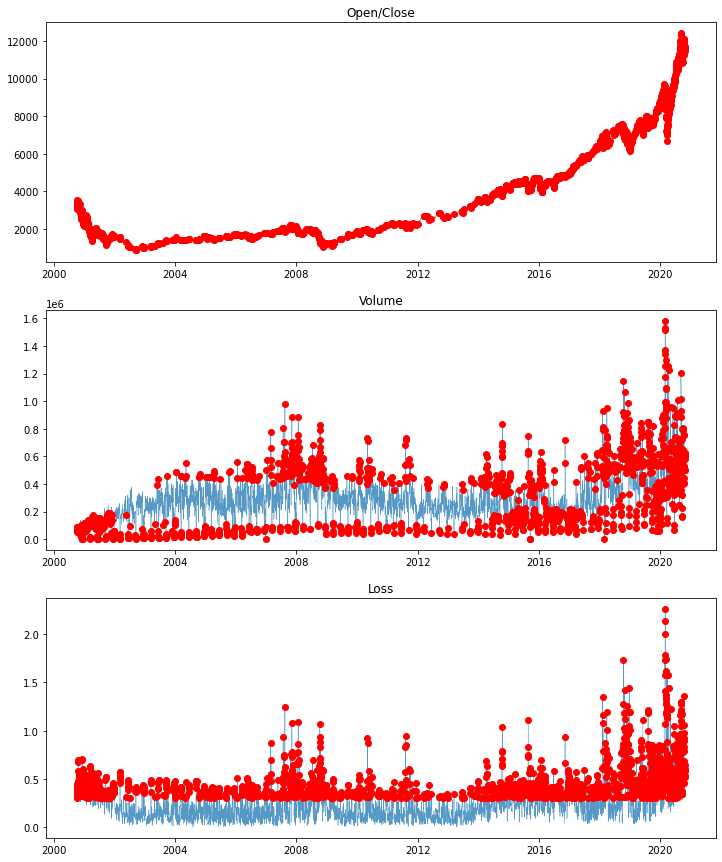

In [65]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])